C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\distributed\node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 2044 instead
  warnings.warn(


dask.array<array, shape=(195, 22), dtype=float64, chunksize=(195, 22), chunktype=numpy.ndarray>
dask.array<array, shape=(195,), dtype=int64, chunksize=(195,), chunktype=numpy.ndarray>
dask.array<from-value, shape=(39, 22), dtype=float64, chunksize=(39, 22), chunktype=numpy.ndarray>
dask.array<from-value, shape=(156, 22), dtype=float64, chunksize=(156, 22), chunktype=numpy.ndarray>
dask.array<from-value, shape=(39,), dtype=int64, chunksize=(39,), chunktype=numpy.ndarray>
dask.array<from-value, shape=(39,), dtype=int64, chunksize=(39,), chunktype=numpy.ndarray>


Exception in thread Thread-37:
Traceback (most recent call last):
  File "C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\threading.py", line 973, in _bootstrap_inner
    self.run()
  File "C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\dask_xgboost\tracker.py", line 365, in join
    while self.thread.isAlive():
AttributeError: 'Thread' object has no attribute 'isAlive'


dask.array<_predict_part, shape=(39,), dtype=float32, chunksize=(39,), chunktype=numpy.ndarray>
dask.array<from-value, shape=(39,), dtype=int64, chunksize=(39,), chunktype=numpy.ndarray>


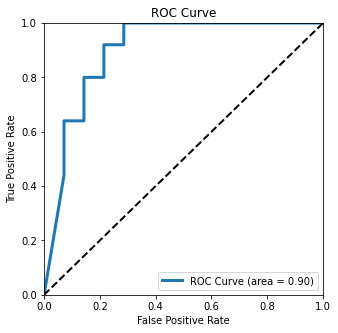

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:2044/status,
Dashboard: http://127.0.0.1:2044/status,Workers: 6
Total threads: 24,Total memory: 11.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:2045,Workers: 6
Dashboard: http://127.0.0.1:2044/status,Total threads: 24
Started: Just now,Total memory: 11.18 GiB
Comm: tcp://127.0.0.1:2105,Total threads: 4
Dashboard: http://127.0.0.1:2106/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:2049,


C:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\statistics.py:168: RuntimeWarning: overflow encountered in long_scalars
  partials[d] = partials_get(d, 0) + n


In [17]:
from dask.distributed import Client, progress
client = Client(n_workers=6, threads_per_worker=4, processes=True, memory_limit='2GB')
import dask.dataframe as dd
from dask import compute, persist
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


# Create the dataframe
df=pd.read_csv('E:\\data sets\\1\\parkinsons.data')
df.head()
X=df.loc[:,df.columns!='status'].values[:,1:]
y=df.loc[:,'status'].values
scaler=MinMaxScaler((-1,1))
x=scaler.fit_transform(X)



x, y = persist(x, y)  # Ask Dask to start work on these in the background

progress(x, y)
#df2 = dd.get_dummies(df.categorize()).persist()
import dask.array as da
a = da.from_array(x) 
b = da.from_array(y)
print(a)
print(b)
from dask_ml.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(a, b, test_size=0.2, random_state=7)
print(x_test)
print(x_train)
print(y_test)
print(y_test)
import dask
import xgboost
import dask_xgboost
import dask_xgboost as dxgb

params = {'objective': 'binary:logistic', 'nround': 1000, 
          'max_depth': 16, 'eta': 0.01, 'subsample': 0.5, 
          'min_child_weight': 1,
          'tree_method': 'hist', 'grow_policy': 'lossguide' }  # these extra paramters recommended by @ogrisel

bst = dxgb.train(client, params, x_train, y_train)
bst
y_hat = dask_xgboost.predict(client, bst, x_test).persist()
print(y_hat)
print(y_test)
from sklearn.metrics import roc_auc_score, roc_curve



#print(roc_auc_score(labels_test.compute(), predictions.compute()))
import matplotlib.pyplot as plt
%matplotlib inline
fpr, tpr, _ = roc_curve(y_test.compute(), y_hat.compute())
from sklearn.metrics import auc

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, lw=3,
        label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend();
plt.show()
client